# Collaborative Filtering Tutorial

## Training a Model

In [1]:
from fastai2.tabular.all import *
from fastai2.collab import *

In [3]:
# we will use the data from Movielens 100K dataset
path = untar_data(URLs.ML_100k)
path.ls()

(#23) [Path('C:/Users/Archel/.fastai/data/ml-100k/allbut.pl'),Path('C:/Users/Archel/.fastai/data/ml-100k/mku.sh'),Path('C:/Users/Archel/.fastai/data/ml-100k/README'),Path('C:/Users/Archel/.fastai/data/ml-100k/u.data'),Path('C:/Users/Archel/.fastai/data/ml-100k/u.genre'),Path('C:/Users/Archel/.fastai/data/ml-100k/u.info'),Path('C:/Users/Archel/.fastai/data/ml-100k/u.item'),Path('C:/Users/Archel/.fastai/data/ml-100k/u.occupation'),Path('C:/Users/Archel/.fastai/data/ml-100k/u.user'),Path('C:/Users/Archel/.fastai/data/ml-100k/u1.base')...]

In [4]:
# ratings dataframe
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                     usecols=(0,1,2), names=['user', 'movie', 'rating'])
ratings.head()

,user,movie,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [6]:
pd.read_csv(path/'u.data', delimiter='\t', header=None).head()

,0,1,2,3
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [11]:
# movies dataframe
movies = pd.read_csv(path/'u.item', delimiter='|', encoding='latin-1',
                    usecols=(0,1), names=['movie', 'title'], header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [15]:
pd.read_csv(path/'u.item', delimiter='|', header=None).head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%20(1995),0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(1995),0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%20(1995),0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [16]:
# merge ratings and movies dataframe
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,title
0,196,242,3,Kolya (1996)
1,63,242,3,Kolya (1996)
2,226,242,5,Kolya (1996)
3,154,242,3,Kolya (1996)
4,306,242,5,Kolya (1996)


In [17]:
# create DataLoaders
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64) # specify the item_name to 'title' instead of movie id in 'movie'

In [18]:
dls.show_batch()

,user,title,rating
0,8,Alien (1979),5
1,833,Twelve Monkeys (1995),3
2,385,Gone with the Wind (1939),1
3,619,"Game, The (1997)",2
4,940,Big Night (1996),3
5,207,Home for the Holidays (1995),3
6,301,Forrest Gump (1994),5
7,387,Richard III (1995),4
8,436,"Candidate, The (1972)",4
9,621,Congo (1995),3


In [19]:
# create collaborative filtering learner
learn = collab_learner(dls, n_factors=50, y_range=(0,5.5)) # 50 latent factors

In [20]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.981593,0.949758,00:05
1,0.852311,0.868935,00:05
2,0.740185,0.827340,00:05
3,0.590219,0.812413,00:05
4,0.507467,0.813215,00:05


## Interpretation

In [21]:
# retrieve top 10 movies based on rating count
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)',
       'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)',
       'Air Force One (1997)', 'Independence Day (ID4) (1996)'],
      dtype=object)

In [25]:
# movie bias
movie_bias = learn.model.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

In [26]:
mean_ratings = ratings.groupby('title')['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

In [27]:
item0 = lambda o:o[0]
sorted(movie_ratings, key=item0)[:15] # movies with the worst bias

[(tensor(-0.3151),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.3045), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.2979),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.2568), 'Bio-Dome (1996)', 1.903225806451613),
 (tensor(-0.2376), 'Thinner (1996)', 2.4489795918367347),
 (tensor(-0.2359), 'Airheads (1994)', 2.34375),
 (tensor(-0.2288), 'Showgirls (1995)', 1.9565217391304348),
 (tensor(-0.2276), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.2255), 'Kansas City (1996)', 2.260869565217391),
 (tensor(-0.2246), "Pete's Dragon (1977)", 2.7209302325581395),
 (tensor(-0.2232), 'Barb Wire (1996)', 1.9333333333333333),
 (tensor(-0.2225), 'Free Willy 3: The Rescue (1997)', 1.7407407407407407),
 (tensor(-0.2215), 'Island of Dr. Moreau, The (1996)', 2.1578947368421053),
 (tensor(-0.2197), 'Grease 2 (1982)', 2.0),
 (tensor(-0.2185), 'Halloween: The Curse of Michael Myers (1995)', 2.2)]

In [28]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15] # movies with the best bias

[(tensor(0.5920), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.5691), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.5283), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.5113), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.5067), 'As Good As It Gets (1997)', 4.196428571428571),
 (tensor(0.5001), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.4936), 'Apt Pupil (1998)', 4.1),
 (tensor(0.4934), 'Godfather, The (1972)', 4.283292978208232),
 (tensor(0.4805), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.4772), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.4658), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.4612), 'To Kill a Mockingbird (1962)', 4.292237442922374),
 (tensor(0.4594), 'Boot, Das (1981)', 4.203980099502488),
 (tensor(0.4447), 'Usual Suspects, The (1995)', 4.385767790262173),
 (tensor(0.4437), 'Raiders of the Lost Ark (1981)', 4.252380952380952)]

There is definitely a <strong>strong</strong> correlation here!

In [30]:
# let's grab movie weights for each movie in top_movies
movie_w = learn.model.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 50])

In [31]:
# implement PCA to reduce dim
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [33]:
fac0,fac1,fac2 = movie_pca.t()
# 1st dimension
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

In [34]:
# highest score in 1st dimension
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.1373), 'Casablanca (1942)'),
 (tensor(1.1136), 'Close Shave, A (1995)'),
 (tensor(1.1068), "One Flew Over the Cuckoo's Nest (1975)"),
 (tensor(1.0838), 'Wrong Trousers, The (1993)'),
 (tensor(1.0697), 'Lawrence of Arabia (1962)'),
 (tensor(1.0272), 'When We Were Kings (1996)'),
 (tensor(1.0125), 'Ran (1985)'),
 (tensor(1.0119), 'Chinatown (1974)'),
 (tensor(1.0068), 'Godfather, The (1972)'),
 (tensor(0.9991),
  'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)')]

In [36]:
# worst score in 1st dimension
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.3046), 'Home Alone 3 (1997)'),
 (tensor(-1.1699), 'Jungle2Jungle (1997)'),
 (tensor(-1.1408), 'Congo (1995)'),
 (tensor(-1.1301), 'Free Willy 3: The Rescue (1997)'),
 (tensor(-1.1166), 'Leave It to Beaver (1997)'),
 (tensor(-1.1001), 'Shadow Conspiracy (1997)'),
 (tensor(-1.0971), 'Children of the Corn: The Gathering (1996)'),
 (tensor(-1.0882), 'Mortal Kombat: Annihilation (1997)'),
 (tensor(-1.0779), 'Super Mario Bros. (1993)'),
 (tensor(-1.0640), "McHale's Navy (1997)")]

In [37]:
# 2nd dimension
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [38]:
# best
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(0.9437), 'Trainspotting (1996)'),
 (tensor(0.8645), 'Jude (1996)'),
 (tensor(0.7996), 'Ready to Wear (Pret-A-Porter) (1994)'),
 (tensor(0.7883), 'Dracula: Dead and Loving It (1995)'),
 (tensor(0.7820), 'Crumb (1994)'),
 (tensor(0.7764), 'Brazil (1985)'),
 (tensor(0.7673), 'Stupids, The (1996)'),
 (tensor(0.7653), 'Serial Mom (1994)'),
 (tensor(0.7558), 'Lost Highway (1997)'),
 (tensor(0.7550), 'Road to Wellville, The (1994)')]

In [39]:
# worst
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.0562), 'Raiders of the Lost Ark (1981)'),
 (tensor(-1.0530), 'Braveheart (1995)'),
 (tensor(-1.0415), 'Titanic (1997)'),
 (tensor(-0.9972), 'Independence Day (ID4) (1996)'),
 (tensor(-0.9133), 'Forrest Gump (1994)'),
 (tensor(-0.8999), 'Time to Kill, A (1996)'),
 (tensor(-0.8880), 'Star Wars (1977)'),
 (tensor(-0.8777), "Mr. Holland's Opus (1995)"),
 (tensor(-0.8655), 'Hunt for Red October, The (1990)'),
 (tensor(-0.8652), 'American President, The (1995)')]

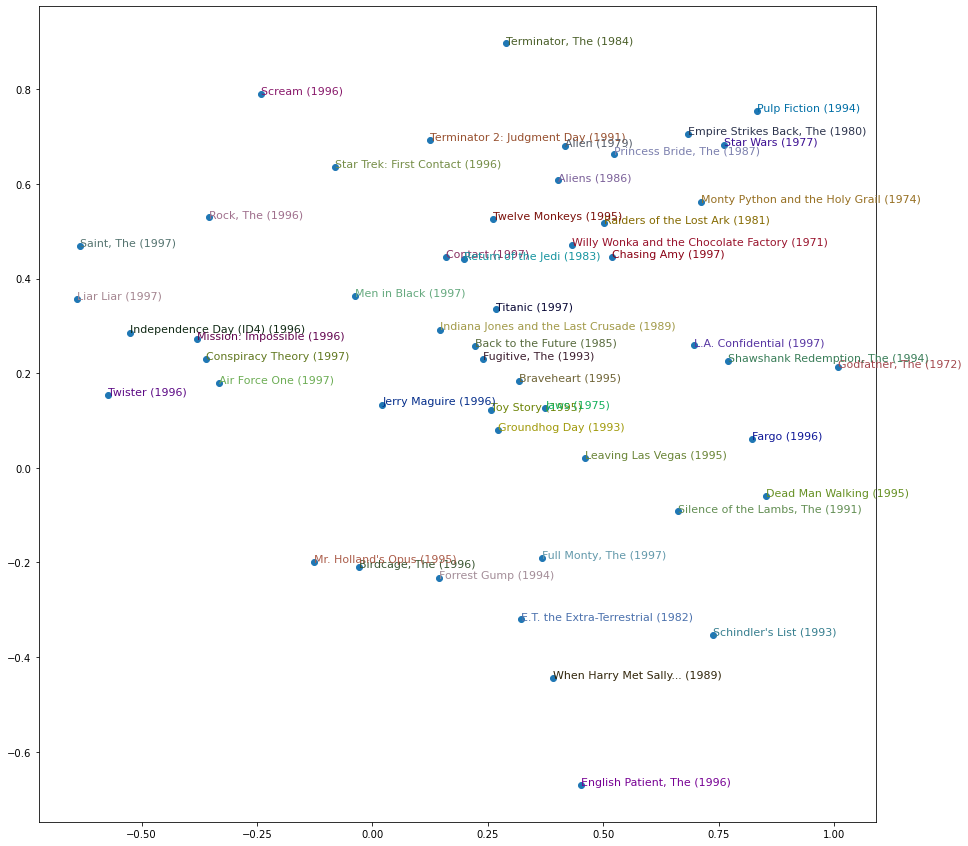

In [40]:
# plot movies according to their scores
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()